FER-2013 Facial Emotion Recognition

1. Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import random_split, DataLoader, Dataset
from PIL import Image 
from torchvision.datasets import ImageFolder

import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


2. Load data and explore

Emotion classes found: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of training images: 28709
Number of testing images: 7178
Training set class distribution:
angry: 3995 images
disgust: 436 images
fear: 4097 images
happy: 7215 images
neutral: 4965 images
sad: 4830 images
surprise: 3171 images
Test set class distribution:
angry: 958 images
disgust: 111 images
fear: 1024 images
happy: 1774 images
neutral: 1233 images
sad: 1247 images
surprise: 831 images


/var/folders/3l/_47vg0dn1s9_g9n8l2vmc4_80000gn/T/ipykernel_12334/2961543049.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(train_counts.keys(), rotation=45)
/var/folders/3l/_47vg0dn1s9_g9n8l2vmc4_80000gn/T/ipykernel_12334/2961543049.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(test_counts.keys(), rotation=45)


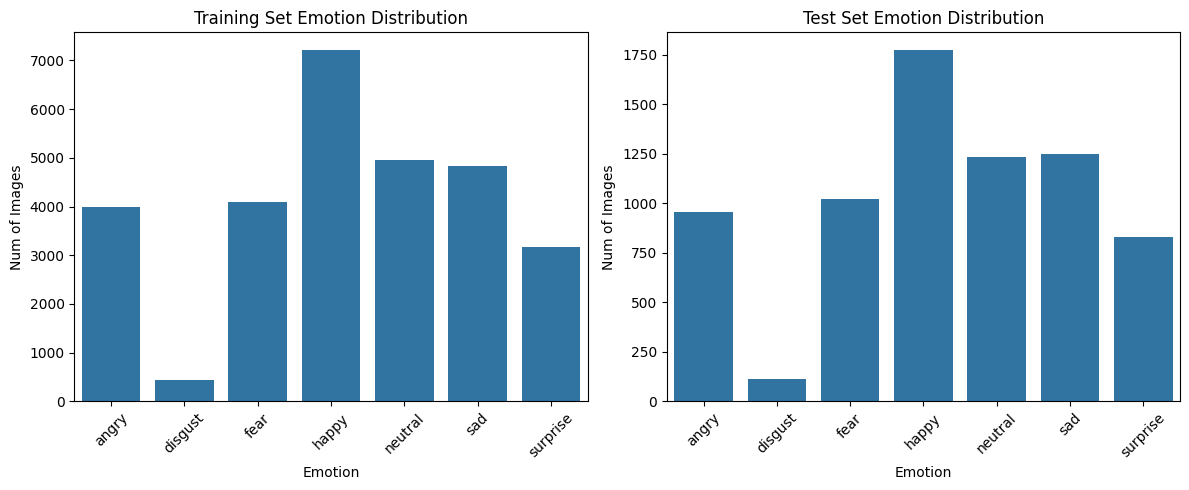

In [2]:
train_dir = './archive/train'
test_dir = './archive/test'

train_dataset = ImageFolder(train_dir, transform=None)
test_dataset = ImageFolder(test_dir, transform=None)

emotion_classes = train_dataset.classes
print(f"Emotion classes found: {emotion_classes}")

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of testing images: {len(test_dataset)}")

train_counts = Counter([emotion_classes[label] for _, label in train_dataset.imgs])
test_counts = Counter([emotion_classes[label] for _, label in test_dataset.imgs])


print("Training set class distribution:")
for emotion, count in train_counts.items():
    print(f"{emotion}: {count} images")

print("Test set class distribution:")    
for emotion, count in test_counts.items():   
    print(f"{emotion}: {count} images")    

fig, axes = plt.subplots(1, 2, figsize=(12, 5))    

sns.barplot(ax=axes[0], x=list(train_counts.keys()), y=list(train_counts.values()))
axes[0].set_title('Training Set Emotion Distribution')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Num of Images')
axes[0].set_xticklabels(train_counts.keys(), rotation=45)

sns.barplot(ax=axes[1], x=list(test_counts.keys()), y=list(test_counts.values()))
axes[1].set_title('Test Set Emotion Distribution')
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Num of Images')
axes[1].set_xticklabels(test_counts.keys(), rotation=45)

plt.tight_layout()
plt.show()



3. Dataloaders, split train & validation and transformations & data augmentation

Training set size: 22967 images
Validation set size: 5742 images
Test set size: 7178 images
Batch image tensor shape: torch.Size([64, 1, 48, 48])
Batch label tensor shape: torch.Size([64])


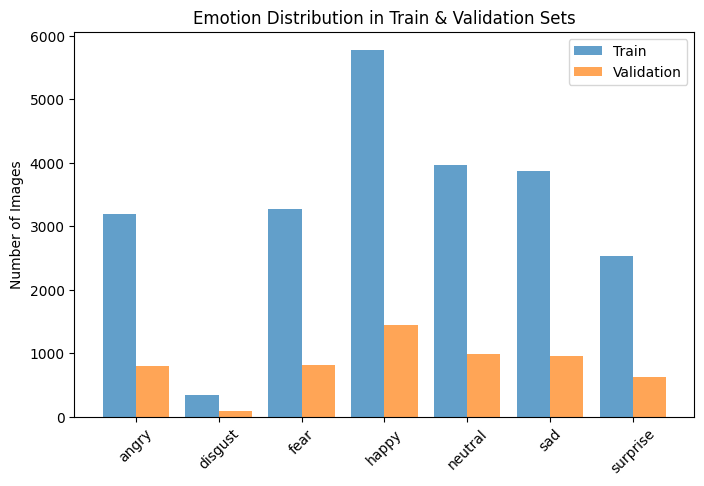

In [3]:
image_paths = []
labels = []
class_to_idx = {
    class_name: idx for idx, class_name in enumerate(
        sorted([d for d in os.listdir('./archive/train') if not d.startswith(".")])
    )
}

for class_name, class_idx in class_to_idx.items():
    class_dir = os.path.join('./archive/train', class_name)
    if not os.path.isdir(class_dir):
        continue
    for image_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_idx)


train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)), 
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, shear=15, scale=(0.75,1.25)),
    transforms.RandomErasing(p=0.2),
    
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = CustomDataset(train_paths, train_labels, transform=train_transform)
val_dataset = CustomDataset(val_paths, val_labels, transform=val_test_transform)

test_dataset = ImageFolder('./archive/test', transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


print(f'Training set size: {len(train_dataset)} images')
print(f'Validation set size: {len(val_dataset)} images')
print(f'Test set size: {len(test_dataset)} images')

images, labels = next(iter(train_loader))
print(f'Batch image tensor shape: {images.shape}')
print(f'Batch label tensor shape: {labels.shape}')

train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
emotion_classes = list(class_to_idx.keys())
train_counts_sorted = [train_counts[i] for i in range(len(emotion_classes))]
val_counts_sorted = [val_counts[i] for i in range(len(emotion_classes))]

fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.4
x = range(len(emotion_classes))

ax.bar(x, train_counts_sorted, width=bar_width, label="Train", alpha=0.7)
ax.bar([i + bar_width for i in x], val_counts_sorted, width=bar_width, label="Validation", alpha=0.7)

ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(emotion_classes, rotation=45)
ax.set_ylabel("Number of Images")
ax.set_title("Emotion Distribution in Train & Validation Sets")
ax.legend()
plt.show()


4. CNN Model 

In [4]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(), nn.Dropout(0.25), nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(0.4)

        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 7)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
model = EmotionCNN().to(device)
print(model)        

EmotionCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.3, inplace=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

5. CNN Model training and validation

Epoch [1/30] - Train Loss: 1.8148 - Train Acc: 23.96% | Val Loss: 1.7690 - Val Acc: 27.03%
Epoch [2/30] - Train Loss: 1.7265 - Train Acc: 29.15% | Val Loss: 1.6006 - Val Acc: 37.50%
Epoch [3/30] - Train Loss: 1.5971 - Train Acc: 36.96% | Val Loss: 1.4950 - Val Acc: 41.36%
Epoch [4/30] - Train Loss: 1.5239 - Train Acc: 40.36% | Val Loss: 1.3879 - Val Acc: 46.27%
Epoch [5/30] - Train Loss: 1.4798 - Train Acc: 42.70% | Val Loss: 1.3710 - Val Acc: 47.51%
Epoch [6/30] - Train Loss: 1.4499 - Train Acc: 43.88% | Val Loss: 1.3106 - Val Acc: 48.80%
Epoch [7/30] - Train Loss: 1.4153 - Train Acc: 45.19% | Val Loss: 1.2775 - Val Acc: 50.02%
Epoch [8/30] - Train Loss: 1.3932 - Train Acc: 46.31% | Val Loss: 1.2545 - Val Acc: 51.08%
Epoch [9/30] - Train Loss: 1.3747 - Train Acc: 47.08% | Val Loss: 1.2540 - Val Acc: 51.22%
Epoch [10/30] - Train Loss: 1.3438 - Train Acc: 47.99% | Val Loss: 1.2135 - Val Acc: 52.28%
Epoch [11/30] - Train Loss: 1.3305 - Train Acc: 48.53% | Val Loss: 1.2101 - Val Acc: 52.9

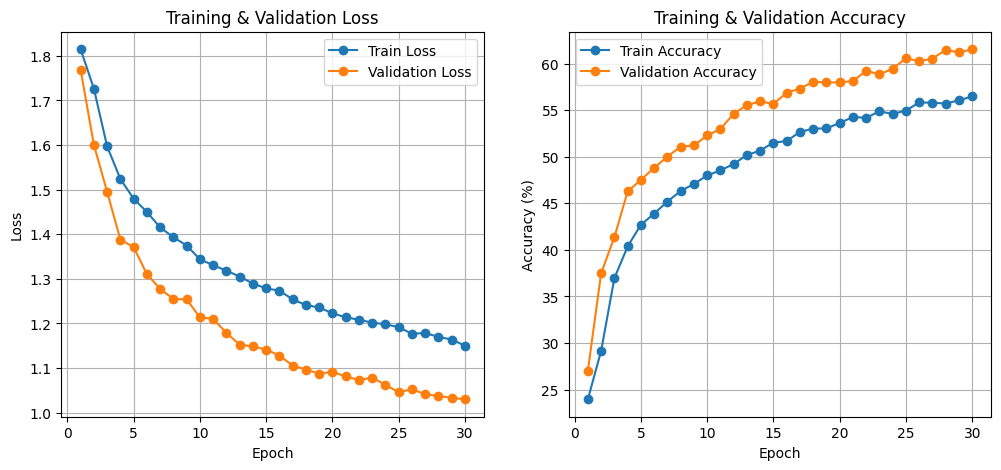

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=0)
epochs = 30 

train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_loss = float("inf")
patience = 5  # Stop training if val loss doesn't improve for 5 epochs
early_stop_counter = 0

for epoch in range(epochs):
    model.train()
    epoch_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        image, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_losses.append(epoch_loss / len(train_loader))
    train_accs.append(train_accuracy)

    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{epochs}] - '
          f'Train Loss: {train_losses[-1]:.4f} - Train Acc: {train_accs[-1]:.2f}% | '
          f'Val Loss: {val_losses[-1]:.4f} - Val Acc: {val_accs[-1]:.2f}%')


    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss curve
axes[0].plot(range(1, epochs+1), train_losses, label="Train Loss", marker="o")
axes[0].plot(range(1, epochs+1), val_losses, label="Validation Loss", marker="o")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend()
axes[0].grid()

# Accuracy curve
axes[1].plot(range(1, epochs+1), train_accs, label="Train Accuracy", marker="o")
axes[1].plot(range(1, epochs+1), val_accs, label="Validation Accuracy", marker="o")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Training & Validation Accuracy")
axes[1].legend()
axes[1].grid()

plt.show()        

       


**Training Per-Class Accuracy:**
angry: 37.77%
disgust: 12.32%
fear: 13.37%
happy: 86.19%
neutral: 63.92%
sad: 63.54%
surprise: 72.13%

**Validation Per-Class Accuracy:**
angry: 41.93%
disgust: 19.54%
fear: 16.46%
happy: 88.15%
neutral: 68.88%
sad: 63.04%
surprise: 76.03%


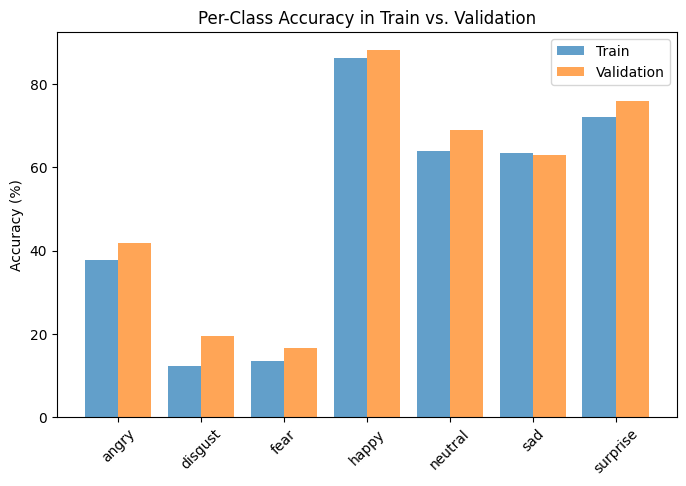

In [11]:
# **Get Training Set Accuracy (After Training)**
model.eval()  # Ensure model is in evaluation mode

all_train_preds = []
all_train_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

# Generate report for training set
train_report = classification_report(all_train_labels, all_train_preds, target_names=emotion_classes, output_dict=True)
print("\n**Training Per-Class Accuracy:**")
train_class_accuracies = {emotion: train_report[emotion]["recall"] * 100 for emotion in emotion_classes}
for emotion, acc in train_class_accuracies.items():
    print(f"{emotion}: {acc:.2f}%")

# **Get Validation Set Accuracy (After Training)**
all_val_preds = []
all_val_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_val_preds.extend(predicted.cpu().numpy())
        all_val_labels.extend(labels.cpu().numpy())

# Generate report for validation set
val_report = classification_report(all_val_labels, all_val_preds, target_names=emotion_classes, output_dict=True)
print("\n**Validation Per-Class Accuracy:**")
val_class_accuracies = {emotion: val_report[emotion]["recall"] * 100 for emotion in emotion_classes}
for emotion, acc in val_class_accuracies.items():
    print(f"{emotion}: {acc:.2f}%")

# **Plot Per-Class Accuracy Comparison**
fig, ax = plt.subplots(figsize=(8,5))

bar_width = 0.4
x = range(len(emotion_classes))

ax.bar(x, list(train_class_accuracies.values()), width=bar_width, label="Train", alpha=0.7)
ax.bar([i + bar_width for i in x], list(val_class_accuracies.values()), width=bar_width, label="Validation", alpha=0.7)

ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(emotion_classes, rotation=45)
ax.set_ylabel("Accuracy (%)")
ax.set_title("Per-Class Accuracy in Train vs. Validation")
ax.legend()
plt.show()

Best model

In [6]:
torch.save(model.state_dict(), "best_facialCNN_model.pth")
print("Model saved as best_facialCNN_model.pth")


Model saved as best_facialCNN_model.pth


Testing on test set

In [7]:
model.eval()  

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 59.81%


Per-Emotion Accuracy:
angry: 39.67%
disgust: 21.62%
fear: 14.36%
happy: 85.46%
neutral: 65.94%
sad: 61.83%
surprise: 77.26%

Full Classification Report:
              precision    recall  f1-score   support

       angry       0.59      0.40      0.47       958
     disgust       0.69      0.22      0.33       111
        fear       0.54      0.14      0.23      1024
       happy       0.81      0.85      0.83      1774
     neutral       0.50      0.66      0.57      1233
         sad       0.42      0.62      0.50      1247
    surprise       0.70      0.77      0.74       831

    accuracy                           0.60      7178
   macro avg       0.61      0.52      0.52      7178
weighted avg       0.61      0.60      0.58      7178



<Figure size 800x600 with 0 Axes>

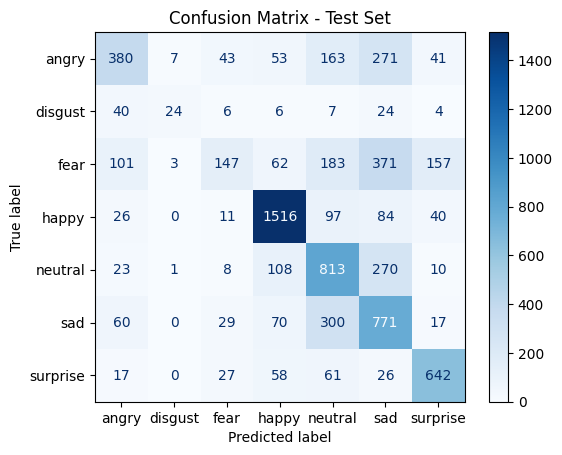

In [10]:
report = classification_report(all_labels, all_preds, target_names=emotion_classes, output_dict=True)

# Print accuracy for each class
print("Per-Emotion Accuracy:")
for emotion, metrics in report.items():
    if emotion in emotion_classes:  # Exclude 'accuracy', 'macro avg', etc.
        emotion_acc = metrics["recall"] * 100  # Recall is equivalent to accuracy per class
        print(f"{emotion}: {emotion_acc:.2f}%")

# Print full classification report
print("\nFull Classification Report:")
print(classification_report(all_labels, all_preds, target_names=emotion_classes))

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=emotion_classes)
plt.figure(figsize=(8,6))
disp.plot(cmap="Blues", values_format=".0f")
plt.title("Confusion Matrix - Test Set")
plt.show()